In [15]:
import os, json
import h5py
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread

%matplotlib inline

In [80]:
SCORES_FILE = 'data/scores.h5'
IMAGE_FILE = 'data/ilsvrc14-50k-det.h5'
JSON_FILE = 'data/ilsvrc14-50k-det.json'

with open(JSON_FILE, 'r') as f:
  json_data = json.load(f)
  val_idx_to_image_id = {int(k): v for k, v in json_data['val_idx_to_image_id'].iteritems()}

with h5py.File(SCORES_FILE, 'r') as scores_file:
  val_scores = np.asarray(scores_file['val_scores'])
  val_labels = np.asarray(scores_file['val_labels'])

print val_scores.shape, val_scores.dtype, val_labels.shape, val_labels.dtype

(20121, 200) float32 (20121, 200) uint8


In [87]:
# Dump image ids to disk
with open('data/val_image_filenames.txt', 'w') as f:
  for idx, image_id in sorted(val_idx_to_image_id.iteritems()):
    f.write('%s.JPEG\n' % image_id)

data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00000007.JPEG


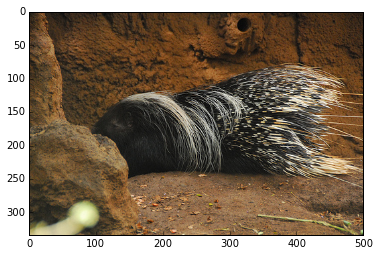

In [90]:
DET_VAL_DIR = 'data/imagenet/ILSVRC2013_DET_val'

def load_val_image(image_id):
  path = os.path.join(DET_VAL_DIR, '%s.JPEG' % image_id)
  print path
  return imread(path)

plt.imshow(load_val_image(val_idx_to_image_id[2]))

1


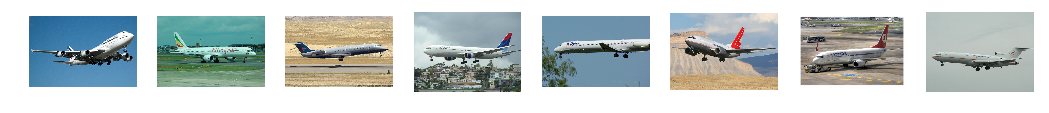

In [82]:
# As a sanity check, show the top classified images for a couple classes
name = 'airplane'
num_to_show = 8

det_id = json_data['name_to_det_id'][name] - 1
print det_id
order = np.argsort(val_scores[:, det_id])[::-1]

for i, idx in enumerate(order[:num_to_show]):
  image_id = val_idx_to_image_id[idx]
  img = load_val_image(image_id)
  plt.subplot(1, num_to_show, i + 1)
  plt.imshow(img)
  plt.axis('off')
plt.gcf().set_size_inches(18, 5)
plt.show()

In [83]:
names_subset = [
  'airplane',
  'ant',
  'bear',
  'bird',
  'camel',
  'car',
  'chair',
  'dog',
  'domestic cat',
  'drum',
  'elephant',
  'goldfish',
  'frog',
  'guitar',
  'hamburger',
  'hammer',
  'horse',
  'laptop',
  'piano',
  'pineapple',
  'miniskirt',
  'table',
  'tie',
  'tiger',
  'toaster',
  'train',
  'turtle',
  'zebra',
  'banana',
  'bowl',
  'syringe',
  'flute',
  'lamp',
  'nail',
  'spatula',
]

for name in names_subset:
  assert name in json_data['name_to_det_id']

# det ids are 1-indexed so we need to subtract one
det_ids_subset = [int(json_data['name_to_det_id'][name]) for name in names_subset]
det_ids_subset = np.asarray(det_ids_subset) - 1

print det_ids_subset

[  1   2  19  25  34  36  42  57  58  60  63  74  71  78  81  82  91 100
 124 125 111 176 180 181 182 184 187 199  12  29 175  68  99 115 164]


Overall accuracy:  0.807446051696
[[  42.    0.    0. ...,    0.    0.    0.]
 [   0.   23.    0. ...,    0.    1.    0.]
 [   0.    0.  103. ...,    0.    0.    0.]
 ..., 
 [   0.    0.    0. ...,   41.    0.    0.]
 [   0.    0.    0. ...,    0.   30.    0.]
 [   0.    0.    0. ...,    0.    1.   11.]]
0.807446051696


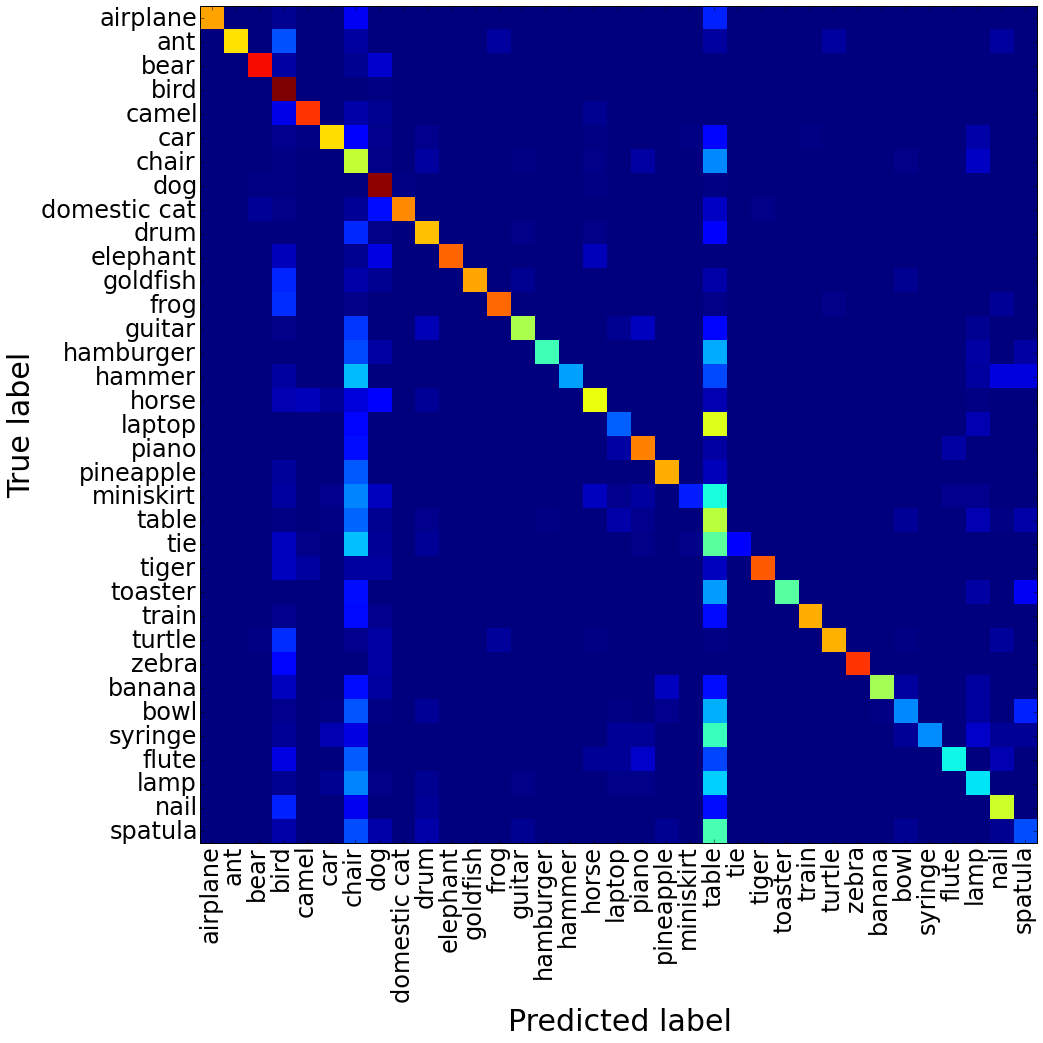

In [84]:
# Right now val_scores and val_labels are 20k x 200; we want to slice down to N x 36

val_scores_subset = val_scores[:, det_ids_subset]
val_labels_subset = val_labels[:, det_ids_subset]

# We only want images with exactly one label
img_mask = val_labels_subset.sum(axis=1) == 1

val_scores_subset = val_scores_subset[img_mask, :]
val_labels_subset = val_labels_subset[img_mask, :]

argmax_label = val_scores_subset.argmax(axis=1)
true_label = val_labels_subset.argmax(axis=1)
print 'Overall accuracy: ', (argmax_label == true_label).mean()

# Now actually compute the confusion matrix.
# Just use loops because I'm lazy.
num_categories = len(names_subset)
confusion = np.zeros((num_categories, num_categories))
for c1 in xrange(num_categories):
  true_label_mask = (true_label == c1)
  for c2 in xrange(num_categories):
    # How many times did we have a true label of c1 and predict a label of c2?
    argmax_label_mask = (argmax_label == c2)
    confusion[c1, c2] = np.logical_and(true_label_mask, argmax_label_mask).sum()
    
print confusion
print np.diag(confusion).sum() / confusion.sum()

confusion_normed = confusion / confusion.sum(axis=1, keepdims=True)
plt.imshow(confusion_normed, interpolation='nearest')
plt.gcf().set_size_inches(15, 15)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)
plt.yticks(range(num_categories), names_subset, fontsize=24)
plt.xticks(range(num_categories), names_subset, rotation=90, fontsize=24)
plt.show()